(121296, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121296 entries, 0 to 121295
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   timestamp             121296 non-null  datetime64[ns]
 1   load_mw               121296 non-null  float64       
 2   temperature_2m        121296 non-null  float64       
 3   relative_humidity_2m  121296 non-null  float64       
 4   dew_point_2m          121296 non-null  float64       
 5   apparent_temperature  121296 non-null  float64       
 6   precipitation         121296 non-null  float64       
 7   weathercode           121296 non-null  int64         
 8   wind_speed_10m        121296 non-null  float64       
 9   wind_direction_10m    121296 non-null  int64         
 10  cloudcover            121296 non-null  float64       
 11  timestamp_local       121296 non-null  object        
 12  hour                  121296 non-null  int64 

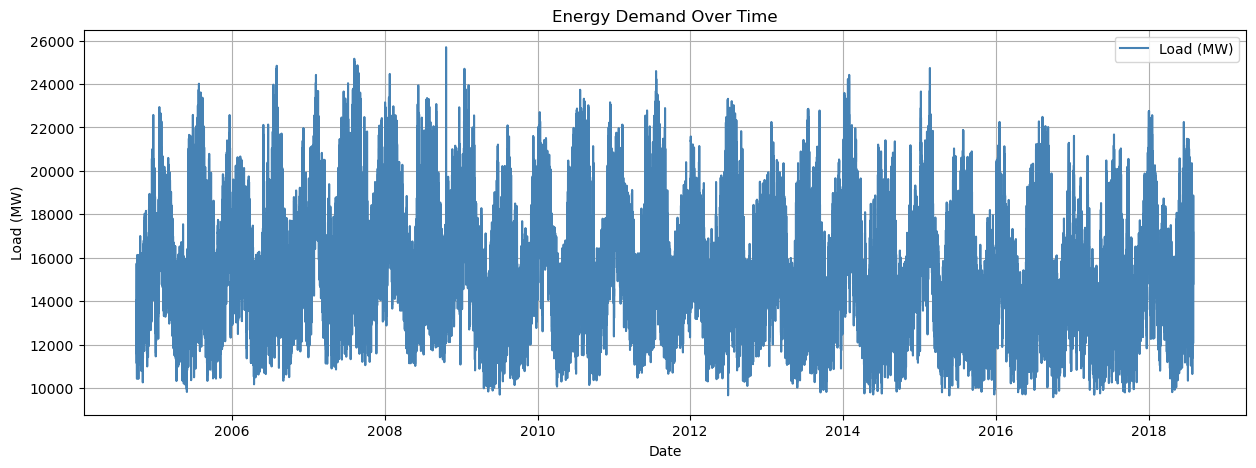

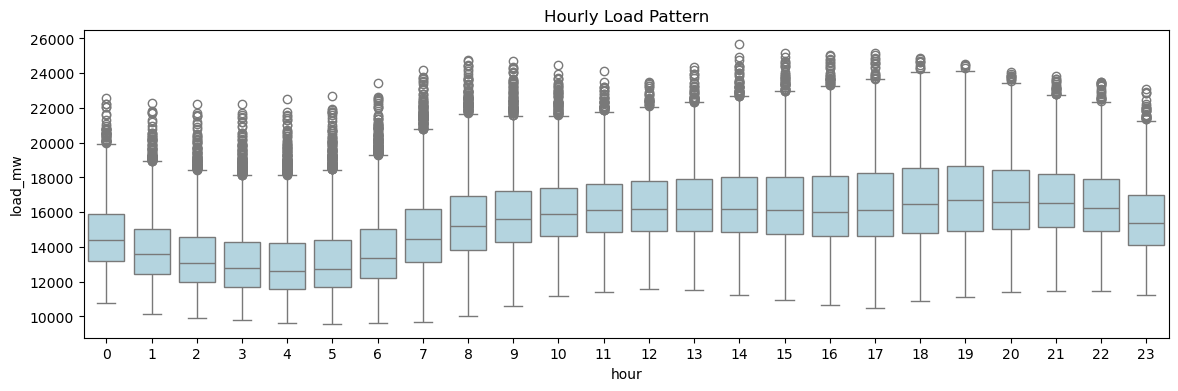

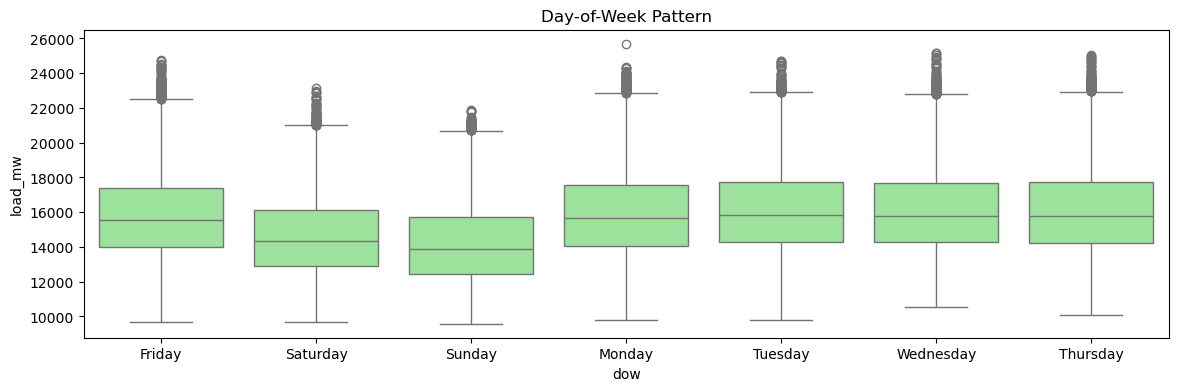

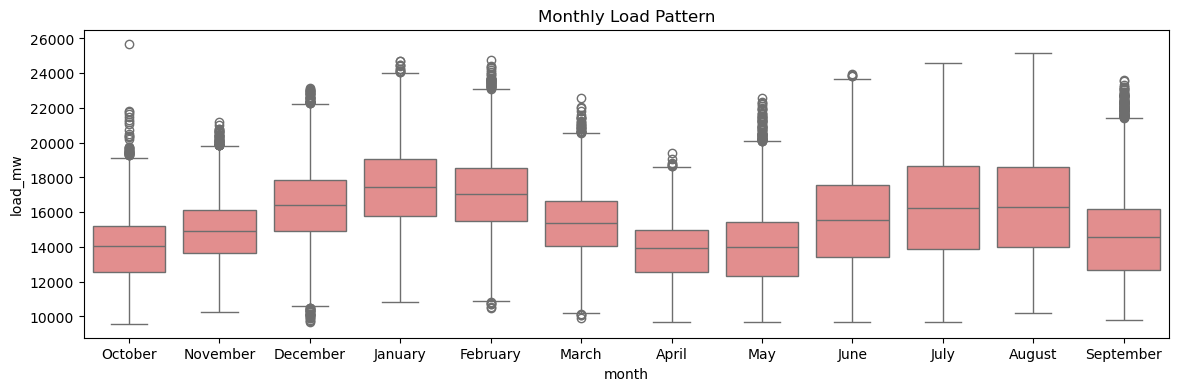

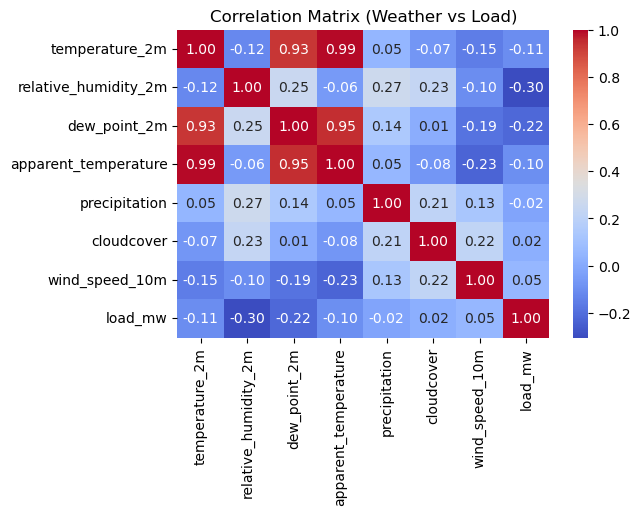

C:\Users\pc\AppData\Local\Temp\ipykernel_28008\1127546433.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_naive = test['load_mw'].shift(1).fillna(method='bfill').values
C:\Users\pc\AppData\Local\Temp\ipykernel_28008\1127546433.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_24h = test['load_lag_24h'].fillna(method='bfill').values
C:\Users\pc\AppData\Local\Temp\ipykernel_28008\1127546433.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_168h = test['load_lag_168h'].fillna(method='bfill').values


Naive → MAPE: 2.81 %
24h Seasonal → MAPE: 6.24 %
168h Weekly → MAPE: 9.62 %


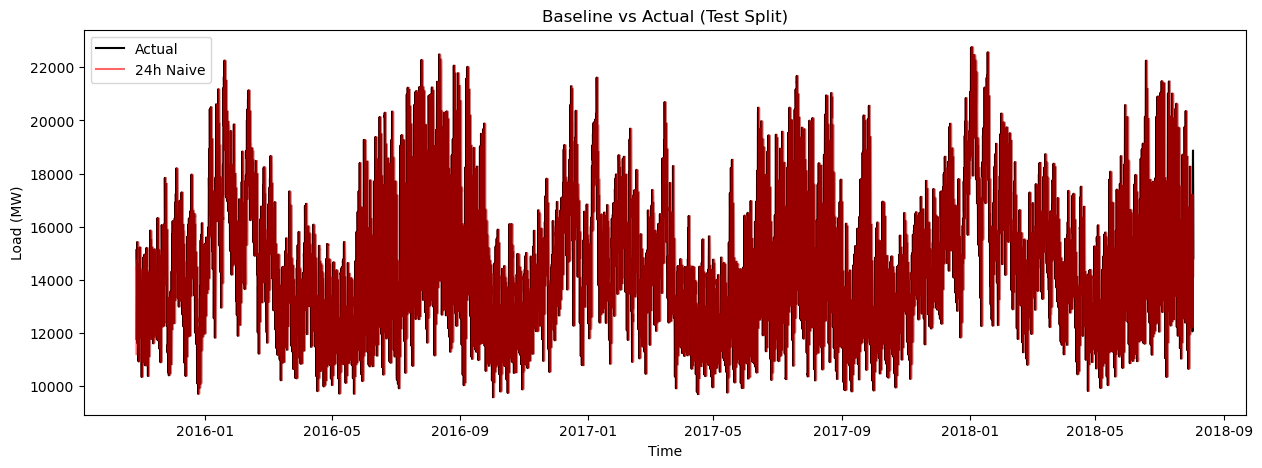

In [1]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 2. Load merged dataset ---
data_path = Path("../data/processed/dataset_merged.csv")
df = pd.read_csv(data_path, parse_dates=["timestamp"])

print(df.shape)
df.head()

# --- 3. Quick info ---
df.info()
df.describe(include='all').T.head(15)

# --- 4. Check missing data ---
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

# --- 5. Plot target ---
plt.figure(figsize=(15,5))
plt.plot(df['timestamp'], df['load_mw'], label='Load (MW)', color='steelblue')
plt.title('Energy Demand Over Time')
plt.xlabel('Date'); plt.ylabel('Load (MW)')
plt.legend(); plt.grid(True)
plt.show()

# --- 6. Seasonal pattern check ---
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['dow'] = pd.to_datetime(df['timestamp']).dt.day_name()
df['month'] = pd.to_datetime(df['timestamp']).dt.month_name()

plt.figure(figsize=(14,4))
sns.boxplot(data=df, x='hour', y='load_mw', color='lightblue')
plt.title('Hourly Load Pattern')
plt.show()

plt.figure(figsize=(14,4))
sns.boxplot(data=df, x='dow', y='load_mw', color='lightgreen')
plt.title('Day-of-Week Pattern')
plt.show()

plt.figure(figsize=(14,4))
sns.boxplot(data=df, x='month', y='load_mw', color='lightcoral')
plt.title('Monthly Load Pattern')
plt.show()

# --- 7. Correlation with weather ---
num_cols = ['temperature_2m','relative_humidity_2m','dew_point_2m','apparent_temperature','precipitation','cloudcover','wind_speed_10m']
corr = df[num_cols + ['load_mw']].corr()['load_mw'].sort_values()
corr

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols + ['load_mw']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix (Weather vs Load)')
plt.show()

# --- 8. Baseline models ---
# Define metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Sort and create lag
df = df.sort_values('timestamp')
df['load_lag_24h'] = df['load_mw'].shift(24)
df['load_lag_168h'] = df['load_mw'].shift(168)

test_ratio = 0.2
split = int(len(df)*(1-test_ratio))
train, test = df.iloc[:split], df.iloc[split:]

# --- Baseline 1: Naive (y_hat = last hour) ---
y_true = test['load_mw'].values
y_pred_naive = test['load_mw'].shift(1).fillna(method='bfill').values
print("Naive → MAPE:", round(mape(y_true, y_pred_naive),2), "%")

# --- Baseline 2: 24h Seasonal Naive (y_hat = same hour yesterday) ---
y_pred_24h = test['load_lag_24h'].fillna(method='bfill').values
print("24h Seasonal → MAPE:", round(mape(y_true, y_pred_24h),2), "%")

# --- Baseline 3: 168h Weekly Seasonal Naive ---
y_pred_168h = test['load_lag_168h'].fillna(method='bfill').values
print("168h Weekly → MAPE:", round(mape(y_true, y_pred_168h),2), "%")

# --- 9. Plot predictions vs actual for visual sanity ---
plt.figure(figsize=(15,5))
plt.plot(test['timestamp'], y_true, label='Actual', color='black')
plt.plot(test['timestamp'], y_pred_24h, label='24h Naive', color='red', alpha=0.6)
plt.legend(); plt.title("Baseline vs Actual (Test Split)")
plt.xlabel("Time"); plt.ylabel("Load (MW)")
plt.show()
